## Регрессионные методы анализа зависимых данных

Мы с вами посмотрели на методы, используемые для анализа CTR в индустрии, и убедились, что работают они вполне корректно. И если ваша цель - это просто сравнение двух групп "стало лучше или нет", то вам, в общем-то, больше ничего особо и не нужно.

Но представим, что ваш интерес зашёл чуть дальше; вы хотите оценить взаимосвязь некоторой дополнительной переменной с нашей метрикой. Например, у вас есть все основания предполагать, что CTR будет зависеть от возраста пользователя, и вы хотите проанализировать эту взаимосвязь на своих данных. Может, она даже меняется в зависимости от того, оказался ли пользователь в контрольной или экспериментальной группе - дополнительный потенциально интересный эффект! Здесь нам уже просто так не обойтись прошлыми методами; нам нужен **регрессионный анализ**.

Но какой регрессионный анализ подойдёт для переменных с зависимыми наблюдениями? Да, мы можем линеаризовать нашу метрику и работать как есть, но вдруг нам хочется остаться в оригинальных единицах измерения? Здесь мы рассмотрим две большие группы методов, которые умеют работать с такими данными. Пока что цель - просто понять, насколько хорошо они могут сравнивать две группы а-ля A/B-тест, дополнительные показатели я (пока что) включать не буду. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm #понадобится нам для вспомогательных штук
import statsmodels.formula.api as smf #собственно, регрессионное моделирование
import seaborn as sns
from tqdm.auto import tqdm
from joblib import Parallel, delayed #параллелизация процессов
from tqdm_joblib import tqdm_joblib #шкала прогресса для параллельных процессов


import warnings
warnings.filterwarnings("ignore") #уберём предупреждения, чтобы не мешались

In [2]:
def generate_ctr_raw(rng, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, multiplier=1.0):

    #генерируем вероятности просмотров
    p_views=rng.beta(a=a_views, b=b_views, size=n)
    #генерируем вероятности лайков (и делаем мультипликативный сдвиг)
    p_likes=rng.beta(a=a_likes, b=b_likes, size=n) * multiplier

    #генерируем количество просмотренных постов каждым пользователем
    views = rng.binomial(n=total_posts, p=p_views, size=n)
    #генерируем событие лайка-нелайка для каждого пользователя
    likes = np.concatenate([rng.binomial(n=1, p=p, size=size) for p, size in zip(p_likes, views)])

    #айдишники пользователей
    user_ids = np.arange(0, n, 1)
    #повторяем каждый, чтобы соответствовало событиям
    user_ids = np.repeat(user_ids, views)

    #возвращаем датафрейм
    return(pd.DataFrame({"user":user_ids, "is_liked":likes}))

In [3]:
control = generate_ctr_raw(rng=np.random.default_rng(2112))
test = generate_ctr_raw(rng=np.random.default_rng(2113), multiplier=1.1)

In [4]:
control

,user,is_liked
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
...,...,...
24722,999,0
24723,999,1
24724,999,0
24725,999,0


In [5]:
test

,user,is_liked
0,0,1
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
24950,999,0
24951,999,0
24952,999,0
24953,999,0


Чтобы регрессия работала как надо, нам нужно объединить наши наборы данных в один датафрейм и разметить, к какой группе принадлежит каждое наблюдение.

In [6]:
control["group"] = "control"
control

,user,is_liked,group
0,0,0,control
1,0,0,control
2,0,0,control
3,0,1,control
4,0,0,control
...,...,...,...
24722,999,0,control
24723,999,1,control
24724,999,0,control
24725,999,0,control


При этом нам надо ещё учесть, что пользователь с айдишником 0 в контроле и с айдишником 0 в тесте - это два разных человека. Чтобы не возникло путаницы, я просто прибавлю к айдишникам тестовой группы число уникальных пользователей в контроле. Таким образом, *пользователь 0 станет пользователем 1000*. 

In [7]:
test["user"] = test["user"] + control.user.nunique()
test["group"] = "test"
test

,user,is_liked,group
0,1000,1,test
1,1000,0,test
2,1000,0,test
3,1000,0,test
4,1000,1,test
...,...,...,...
24950,1999,0,test
24951,1999,0,test
24952,1999,0,test
24953,1999,0,test


Теперь можно объединять датафреймы:

In [8]:
total = pd.concat([control, test])
total

,user,is_liked,group
0,0,0,control
1,0,0,control
2,0,0,control
3,0,1,control
4,0,0,control
...,...,...,...
24950,1999,0,test
24951,1999,0,test
24952,1999,0,test
24953,1999,0,test


Супер! Теперь давайте применим на этом датафрейме для демонстрации классическую линейную регрессию. Мы уже говорили о том, что это фактически более изощрённый способ делать t-тест с эквивалентным результатом - соответственно, она должна плохо контролировать ошибку I рода. Остальные модели должны справиться лучше.

In [9]:
simple_glm = smf.ols("is_liked ~ group", total).fit()
simple_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               is_liked   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     25.94
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           3.54e-07
Time:                        16:23:58   Log-Likelihood:                -26181.
No. Observations:               49682   AIC:                         5.237e+04
Df Residuals:                   49680   BIC:                         5.238e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2044      0.003     78.402      0.000       0.199       0.209
group[T.test]     0.0187      0.004      5.093      0.000       0.012       0.026
==============================================================================
Omnibus:                     9415.645   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16126.760
Skew:                           1.395   Prob(JB):                         0.00
Kurtosis:                       2.950   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Смотрим на стандартную ошибку:

In [10]:
simple_glm.bse

Intercept        0.002606
group[T.test]    0.003678
dtype: float64

Для нашей переменной группы она равна 0.003678 - как раз в том диапазоне значений, который был у t-теста. Значит, как и ожидалось, мы не контролируем ошибку I рода на должном уровне. 

Давайте смотреть на альтернативы.

## Линейные модели со смешанными эффектами (linear mixed effects models, LME)

Эти модели безумно любят в науках о жизни и социальных науках - и особенно их ценят психологи. Основная хитрость LME заключается в том, что она разделяет оцениваемые параметры на две категории - **фиксированные эффекты** и **случайные эффекты**. 

1. **Фиксированные эффекты (fixed effects)** - это эффекты, общие для интересующей нас генеральной совокупности. Они завязаны на некоторые переменные, в которых нас интересует полный набор значений. В нашем случае это эффект, связанный с *экспериментальной группой*, т.е. как меняется CTR в зависимости от группы. В этом модель ничем не отличается от обычной линейной регрессии.
2. **Случайные эффекты (random effects)** - это эффекты, которые являются индивидуальными для конкретной части нашей выборки. Считается, что значения соответствующих переменных (факторов) сами по себе случайно отобраны из генеральной совокупности. В нашем случае это как раз эффект *отдельного пользователя* - нас не особо интересует, какое значение CTR выдаёт конкретный пользователь, но мы понимаем, что повторные измерения от одного пользователя вносят свой уникальный вклад в дисперсию данных.

Иными словами, случайные эффекты - это как раз та часть модели, которая завязана на повторные наблюдения и структуры зависимостей между ними. Они принимают следующие формы:

* **Случайный свободный член** - свободный член регрессии варьируется в зависимости от случайного фактора. Это как раз наш случай: у нас есть глобальное, фиксированное значение свободного члена, обозначающее CTR контрольной группы - а есть куча индивидуальных CTR каждого конкретного пользователя. Фактически мы моделируем не только CTR контрольной и экспериментальной группы (фиксированная часть), но ещё и каждый индивидуальный CTR пользователя (случайная часть) - и всё это учитывается в расчётах статистической значимости.
* **Случайный наклон** - сила и характер взаимосвязи варьируется в зависимости от случайного фактора. Для нас это неактуально, но представьте гипотетическую ситуацию: во время эксперимента наш пользователь попадает то в контрольную, то в тестовую группу, и в каждой из них реагирует на изменение по-разному. Например, у одного пользователя CTR мог увеличиться, у другого уменьшиться, у третьего увеличиться, но в меньшей степени. То есть это индивидуальная реакция на изменение экспериментальной группы - и это LME тоже может смоделировать.
* **Случайный свободный член и случайный наклон** - в модели учитывается и то, и другое.

Более того, у нас может быть больше одного случайного фактора за раз! Например, мы могли бы отдельно анализировать эффект пользователя, а отдельно эффект **поста** - наверняка какие-то посты смотрят и лайкают чаще, чем другие! И если нас не интересуют напрямую различия для конкретных постов (стали ли конкретный пост лайкать чаще в тесте), то эту переменную вполне можно использовать как отдельный случайный эффект.

> Я пробовал тут это симулировать, но к сожалению, функция не смогла это посчитать. Потом попробую это смоделировать на R, думаю, там будет работать лучше.

При этом в модели есть определённое допущение: случайные эффекты распределены вокруг фиксированного согласно нормальному распределению. И это порождает самый замечательный феномен этой модели под названием **"сжатие случайных эффектов" (shrinkage)**. Суть сравнительно проста: у нас не просто считается пользовательский CTR, его "утягивает" в направлении фиксированного эффекта. То есть если по всей группе у нас CTR равен 0.2, а у конкретного пользователя он 0.4, то его индивидуальный CTR будет оценён моделью как более низкий. Вот тут есть [прикольная анимация](https://m-clark.github.io/posts/2019-05-14-shrinkage-in-mixed-models/) этого эффекта в зависимости от разных условий.

При этом:

* Чем сильнее отклонение от фиксированного эффекта, тем сильнее "притяжение"
* Чем больше повторных наблюдений на конкретного пользователя, тем *слабее* "притяжение"

То есть можно сказать, что LME решает проблему, которая была связана с пользовательским CTR - чем меньше наблюдений, тем меньший вес имеет конкретный пользователь в оценке дисперсии. Причём мы можем потом извлечь эти индивидуальные CTR и использовать для чего-то другого - например, для выделения наиболее активных пользователей. 

Давайте посмотрим на это своими глазами. Можете видеть, что появился аргумент `groups`, где мы и указываем переменную, обозначающую наш случайный фактор.

In [11]:
mixed_model = smf.mixedlm("is_liked ~ group", total, groups="user").fit()
mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: is_liked   
No. Observations: 49682   Method:             REML       
No. Groups:       2000    Scale:              0.1603     
Min. group size:  6       Log-Likelihood:     -25798.6570
Max. group size:  46      Converged:          Yes        
Mean group size:  24.8                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.203    0.004 53.425 0.000  0.196  0.211
group[T.test]   0.020    0.005  3.673 0.000  0.009  0.030
user Var        0.008    0.001                           
=========================================================

"""

Взглянем на стандартную ошибку - обратите внимание на приписку fe (fixed effects):

In [12]:
mixed_model.bse_fe

Intercept        0.003802
group[T.test]    0.005372
dtype: float64

0.005372 - похоже на то, какое значение реально должно быть (в ноутбуке 2.2 симуляции дали 0.005085)! Вот теперь ошибка I рода должна контролироваться гораздо лучше, но возможно, немного консервативнее.

Обратите ещё внимание на строчку `user Var` в табличке - это *дисперсия случайных эффектов*. То есть по этому числу можно понять, насколько велик разброс пользовательских CTR. Впрочем, мы можем посмотреть на случайные эффекты своими глазами - они сохранены в атрибуте random_effects в виде словаря. Словарь из 2000 значений - немного дофига, поэтому напечатаем только первые 10:

In [16]:
for i in range(10):
    print(mixed_model.random_effects.get(i))

user   -0.021572
dtype: float64
user   -0.071388
dtype: float64
user   -0.02164
dtype: float64
user   -0.02164
dtype: float64
user   -0.102235
dtype: float64
user   -0.04193
dtype: float64
user   -0.006029
dtype: float64
user    0.069858
dtype: float64
user    0.019974
dtype: float64
user    0.094602
dtype: float64


Можете видеть, что часть из этих показателей отрицательная. Это не ошибка - просто эффекты показывают отличие от фиксированного свободного члена. Соответственно, по величине и знаку можно понять, насколько сильно конкретный пользователь отличается от группы и в какую сторону. 

Впрочем, мы можем вывести и индивидуальный CTR - то есть фиксированный эффект + индивидуальный эффект. Это находится в атрибуте `.fittedvalues`:

In [18]:
mixed_model.fittedvalues

0        0.181571
1        0.181571
2        0.181571
3        0.181571
4        0.181571
           ...   
24950    0.205868
24951    0.205868
24952    0.205868
24953    0.205868
24954    0.205868
Length: 49682, dtype: float64

Можно видеть дубликаты, так как размер вывода соответствует числу рядов исходного датафрейма. Давайте добавим эти показатели отдельной колонкой.

In [19]:
total["fitted"] = mixed_model.fittedvalues
total

,user,is_liked,group,fitted
0,0,0,control,0.181571
1,0,0,control,0.181571
2,0,0,control,0.181571
3,0,1,control,0.181571
4,0,0,control,0.181571
...,...,...,...,...
24950,1999,0,test,0.205868
24951,1999,0,test,0.205868
24952,1999,0,test,0.205868
24953,1999,0,test,0.205868


Давайте агрегируем данные, а заодно сравним "наивные" CTR пользователей и оценённые моделью.

In [21]:
total_agg = total.groupby(["user", "group"], as_index=False).agg(views=("is_liked", "count"), 
                                                                 likes=("is_liked", "sum"), 
                                                                 fitted=("fitted", "max"))
total_agg

,user,group,views,likes,fitted
0,0,control,30,5,0.181571
1,1,control,34,3,0.131756
2,2,control,19,3,0.181503
3,3,control,19,3,0.181503
4,4,control,21,0,0.100909
...,...,...,...,...,...
1995,1995,test,27,6,0.222507
1996,1996,test,26,3,0.163067
1997,1997,test,27,2,0.138698
1998,1998,test,21,1,0.134676


Посчитаем "наивный" CTR:

In [22]:
total_agg["user_ctr"] = total_agg["likes"] / total_agg["views"] 
total_agg

,user,group,views,likes,fitted,user_ctr
0,0,control,30,5,0.181571,0.166667
1,1,control,34,3,0.131756,0.088235
2,2,control,19,3,0.181503,0.157895
3,3,control,19,3,0.181503,0.157895
4,4,control,21,0,0.100909,0.000000
...,...,...,...,...,...,...
1995,1995,test,27,6,0.222507,0.222222
1996,1996,test,26,3,0.163067,0.115385
1997,1997,test,27,2,0.138698,0.074074
1998,1998,test,21,1,0.134676,0.047619


Нарисуем "наивный" CTR:

<Axes: xlabel='user_ctr', ylabel='Density'>

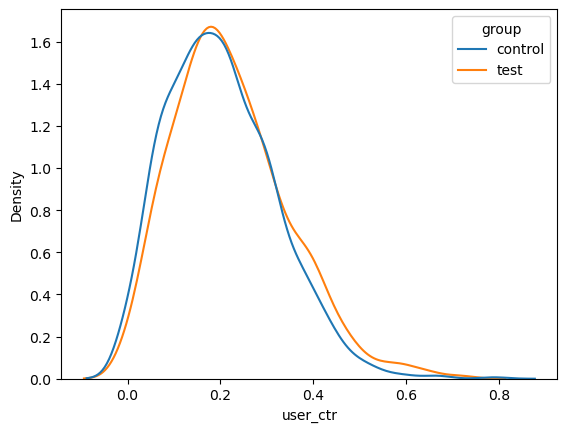

In [24]:
sns.kdeplot(data=total_agg, x="user_ctr", hue="group")

А вот так выглядят оценки модели:

<Axes: xlabel='fitted', ylabel='Density'>

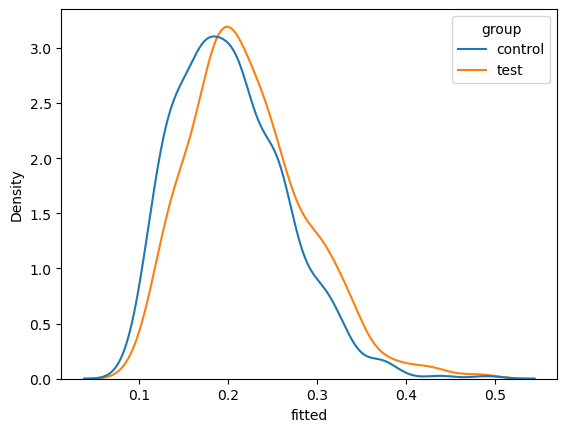

In [25]:
sns.kdeplot(data=total_agg, x="fitted", hue="group")

При сопоставимой форме распределения хорошо видно, что для оценённых моделью значений различие между двумя группами более подчёркнуто! Также можно заметить, что изменилась ось x - её размах стал намного уже.

Наконец, поглядим на корреляцию:

<Axes: xlabel='fitted', ylabel='user_ctr'>

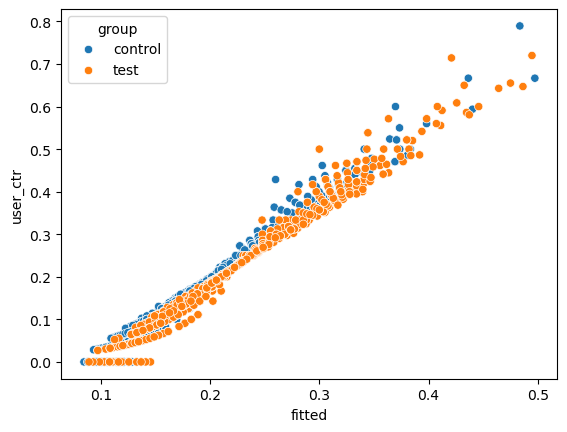

In [26]:
sns.scatterplot(data=total_agg, x="fitted", y="user_ctr", hue="group")

Корреляция видна, но заметно, что она не идеальна. Что и неудивительно, учитывая, что разным наблюдениям давался разный вес.

Окей! Давайте посмотрим, насколько быстро это всё считается.

In [27]:
%timeit smf.mixedlm("is_liked ~ group", total, groups="user").fit()

3.53 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ух. Как видите, за богатую ифнормацию о данных модель берёт большую плату - она выполняется даже дольше, чем бутстрап! Оно и не удивительно, с таким-то числом оцениваемых параметров; и чем больше выборка, тем сильнее это будет сказываться на скорости модели. Она плохо масштабируется - и в этом её большая проблема.

Поэтому для симуляций ниже я подготовился отдельно.

> Изначально я хотел ещё показать логистическую регрессию со смешанными эффектами - да, такая тоже есть, и в statsmodels для неё есть [отдельная функция](https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.html#statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM). К сожалению, во время теста она считалась 5 минут и в итоге выдала ошибка, так что я оставил эту идею. Опять же, в R попробую снова.

### Симулируем

Как всегда, готовим функцию для симуляций:

In [28]:
def mixed_power_uneq(test_prop=1.0, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, alpha=0.05, num_iter=10000, test_multiplier=1.0):

    pvals= [] #складываем p-value
    
    rng = np.random.default_rng() #генератор случайных чисел

    #повторяем процедуру несколько раз
    for _ in tqdm(range(num_iter)):

        control = generate_ctr_raw(rng, n=n, total_posts=total_posts, 
                                   a_views=a_views, b_views=b_views, 
                                   a_likes=a_likes, b_likes=b_likes) #данные контрольной группы
        test = generate_ctr_raw(rng, n=int(n*test_prop), total_posts=total_posts, 
                                a_views=a_views, b_views=b_views, 
                                a_likes=a_likes, b_likes=b_likes, multiplier=test_multiplier) #данные тестовой группы
        
        #объединяем и создаём нужные переменные
        control["group"] = "control"
        test["user"] = test["user"] + control.user.nunique()
        test["group"] = "test"
        total = pd.concat([control, test])

        #сохраняем p-value модели
        pvals.append(smf.mixedlm("is_liked ~ group", total, groups="user").fit().pvalues[1] < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно

    if test_multiplier == 1.0:
        res = "FPR"
    else:
        res = "Power"
    
    return(pd.DataFrame({"Model":["mixed"], 
                         "Sample":[n], "Prop":[test_prop],
                          res:[np.mean(pvals)]}))

А вот дальше я привлекаю к расчётам **параллельные вычисления** - пусть симуляции считаются на нескольких ядрах моего компьютера! Это ощутимо сэкономило мне время вычислений - потребовалось 13-15 часов для каждого из 4 расчётов. Да, это я ещё выиграл - если бы я прогонял симуляции как раньше, процесс мог бы идти несколько дней.

И помогла мне в этом библиотека для параллельных вычислений под названием [joblib](https://joblib.readthedocs.io/en/latest/parallel.html). Пользоваться ей сравнительно просто.

1. Выделяем нужное количество ядер под задачу - в этом помогает класс `Parallel`. В данном случае я задал 6 ядер: `Parallel(n_jobs=6)`.
2. С помощью функции `delayed` привожу функцию в тот формат, который кушает `joblib`: `delayed(mixed_power_uneq)`
3. Внутри объекта, создаваемого классом `Parallel`, я выполняю подготовленную функцию в духе list comprehension. Соответственно, итрации цикла разедляются между ядрами и идут параллельно, насколько это возможно.

К сожалению, шкала прогресаа не работает нормально с `joblib`. К счастью, я нашёл пакет [tqdm-joblib](https://github.com/louisabraham/tqdm_joblib), который позволяет это обойти.

#### FPR

In [17]:
with tqdm_joblib(desc="FPR MIXED", total=11) as progress_bar:
    mixed_fpr = Parallel(n_jobs=6)(delayed(mixed_power_uneq)(n=sample_size) 
                                   for sample_size in range(20, 1100, 100))

FPR MIXED:   0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

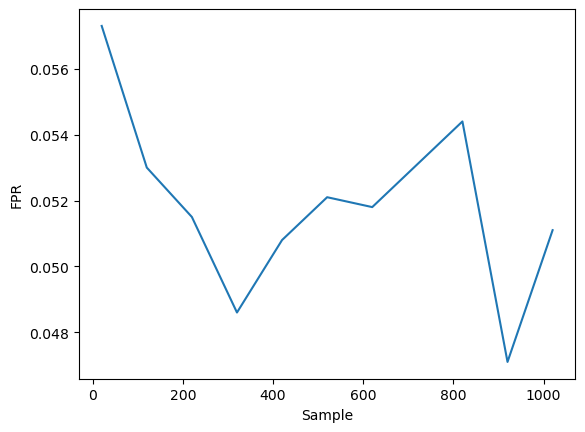

In [18]:
mixed_fpr = pd.concat(mixed_fpr)
sns.lineplot(data=mixed_fpr, x="Sample", y="FPR")

Судя по всему, для маленьких выборок он немного завышен, но в остальном выглядит вполне разумно. Чтобы потом не приходилось перезапускать симуляцию, сохраню её результаты:

In [19]:
mixed_fpr.to_csv("mixed_fpr.csv", index=False)

#### FPR (неравные выборки)

In [20]:
with tqdm_joblib(desc="FPR MIXED UNEQ", total=np.arange(0.05, 1.05, 0.1).size) as progress_bar:
    mixed_fpr_uneq = Parallel(n_jobs=6)(delayed(lambda prop: mixed_power_uneq(test_prop=prop))(sample_size) 
                                        for sample_size in np.arange(0.05, 1.05, 0.1))

FPR MIXED UNEQ:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Prop', ylabel='FPR'>

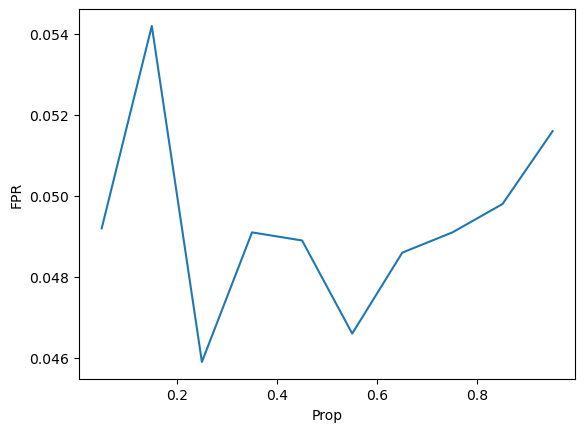

In [21]:
mixed_fpr_uneq = pd.concat(mixed_fpr_uneq)
sns.lineplot(data=mixed_fpr_uneq, x="Prop", y="FPR")

Судя по всему, каких-то особых проблем с диспропорцией размеров выборки модель не испытывает.

In [22]:
mixed_fpr_uneq.to_csv("mixed_fpr_uneq.csv", index=False)

#### Мощность

In [23]:
with tqdm_joblib(desc="POWER MIXED", total=11) as progress_bar:
    mixed_power = Parallel(n_jobs=6)(delayed(lambda samp: mixed_power_uneq(n=samp, test_multiplier=1.1))(sample_size) 
                                     for sample_size in range(20, 1100, 100))

POWER MIXED:   0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

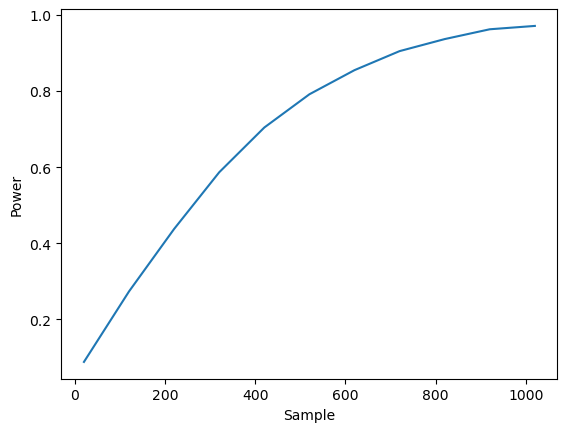

In [24]:
mixed_power = pd.concat(mixed_power)
sns.lineplot(data=mixed_power, x="Sample", y="Power")

Выглядит вполне разумно.

In [25]:
mixed_power.to_csv("mixed_power.csv", index=False)

#### Мощность (неравные выборки)

In [26]:
with tqdm_joblib(desc="POWER MIXED UNEQ", total=np.arange(0.05, 1.05, 0.1).size) as progress_bar:
    mixed_power_uneq = Parallel(n_jobs=6)(delayed(lambda prop: mixed_power_uneq(test_prop=prop, test_multiplier=1.1))(sample_size) 
                                          for sample_size in np.arange(0.05, 1.05, 0.1))

POWER MIXED UNEQ:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Prop', ylabel='Power'>

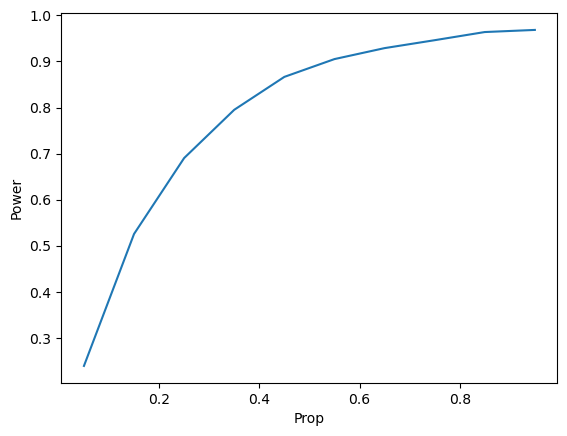

In [27]:
mixed_power_uneq = pd.concat(mixed_power_uneq)
sns.lineplot(data=mixed_power_uneq, x="Prop", y="Power")

Тоже в целом ничего особенного, результат вполне ожидаемый.

In [28]:
mixed_power_uneq.to_csv("mixed_power_uneq.csv", index=False)

Что ж, за пару дней это всё посчиталось, и можно смело сказать, что метод работает - путь и не особо быстро. Однако обратите внимание: большой вклад в такую медленную скорость расчётов вносит необходимость считать параметры случайных эффектов. Что, если они вам не нужны? Что, если вы просто хотите сравнить CTR без лишних страданий, но при этом вам всё ещё нужна регрессионная модель?

Встречайте нашего второго (и последнего) претендента.

## Обобщённые уравнения оценки (generalized estimating equations, GEE)

Этот вариант несколько менее известен, чем LME, но он тоже довольно интересен. Основные концептуальные отличия GEE от LME такие:

* GEE не моделирует индивидуальные эффекты - только эффекты генеральной совокупности. Соответственно, в них оценивается гораздо меньше параметров и они считаются быстрее.
* Если LME - это полностью параметрические модели, где у каждой штуки предполагается некоторое конкретное распределение, то GEE является *полупараметрической моделью* - для каких-то параметров распределение задаётся, для каких-то нет. По факту вычисление коэффициентов в GEE является вопросом оптимальной оптимизации без привязки к функциям правдоподобия.

> Последнее имеет небольшое практическое следствие для сравнения моделей: мы не можем нормально использовать классические [информационные критерии](https://vitalflux.com/aic-vs-bic-for-regression-models-formula-examples/) (AIC и BIC), так как они полагаются на расчёт правдоподобия, которое в GEE считается в лучшем случае частично. Впрочем, в GEE есть свой вариант под названием *псевдо-информационный критерий (quasi-information criterion, QIC)*, поэтому это не такая уж и проблема.

Как же GEE может справиться с зависимыми наблюдениями, если она не моделирует индивидуальные эффекты, как LME? У неё есть два козыря:

1. GEE умеет моделировать структуру зависимостей внутри каждой подгруппы - т.е. корреляции между отдельными наблюдениями одного и того же пользователя. Технически это умеет делать и LME, но GEE гораздо гибче в своих возможностях. Одна из наиболее убийственных возможностей GEE - это *авторегрессивная структура зависимостей*, т.е. корреляции между наблюдениями во времени. Поэтому если есть основания предполагать, что поведение пользователей имеет явную динамику во времени - это очень неплохой вариант.
2. GEE использует так называемые **робастные стандартные ошибки** - способ расчёта стандартных ошибок, устойчивый к нарушениям допущений. Это имеет довольно забавное следствие: даже если вы подберёте абсолютно некорректную структуру зависимостей, модель наверняка всё ещё посчитает адекватную статзначимость; считайте это подушкой безопасности. Впрочем, задавать корректную структуру всё-таки лучше, чем ошибаться - так будет лучше для качества модели и её интерпретации :)

> Такие стандартные ошибки ещё имеют забавное название **сэндвич-оценщиков (sandwich estimators)**. Чтобы понять, почему, просто посмотрите на формулу типичного сэндвича: $[X'X]^{-1}X'VX[X'X]^{-1}$. Видите, что её центр выглядит как будто зажатый между похожими матрицами, словно сосиска между двумя кусками хлеба? Отсюда и название.

Давайте смотреть на эти модели в практике! Но предварительно создадим несколько вспомогательных объектов:

In [29]:
fam_normal = sm.families.Gaussian() #нормальное распределение
fam_binomial = sm.families.Binomial() #биномиальное распределение, логистическая функция связи

cov_ind = sm.cov_struct.Independence() #независимая структура
cov_ex = sm.cov_struct.Exchangeable() #сменяемая структура

### Нормальное распределение, независимая структура

Наш первый вариант модели предполагает нормальное распределение метрики и независимость наблюдений внутри каждой группы. Иными словами, обычная регрессионная модель, но с особыми стандартными ошибками. Можете видеть, что аргументы те же, что и для LME, но добавился `cov_struct` (где мы задаём структуру зависимостей) и `family` (где мы задаём семейство распределения - как в обобщённой линейной модели).

In [30]:
gee_normal_ind = smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ind, family=fam_normal).fit()
gee_normal_ind.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    is_liked   No. Observations:                49682
Model:                                 GEE   No. clusters:                     2000
Method:                        Generalized   Min. cluster size:                   6
                      Estimating Equations   Max. cluster size:                  46
Family:                           Gaussian   Mean cluster size:                24.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 20 Dec 2023   Scale:                           0.168
Covariance type:                    robust   Time:                         22:03:30
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2044      0.004     55.162      0.000       0.197       0.212
group[T.test]     0.0187      0.005      3.458      0.001       0.008       0.029
==============================================================================
Skew:                          1.3953   Kurtosis:                      -0.0499
Centered skew:                 1.2289   Centered kurtosis:              0.0139
==============================================================================
"""

Смотрим на стандартную ошибку:

In [31]:
gee_normal_ind.bse

Intercept        0.003705
group[T.test]    0.005417
dtype: float64

Примерно такая же, как и у LME - но ещё чуть-чуть повыше. Судя по всему, LME немного чувствительнее в данном случае.

Можем ещё глянуть на объект, содержащий в себе структуру зависимостей. Как и ожидается, текст пишет про независимость наблюдений внутри группы.

In [34]:
gee_normal_ind.cov_struct.summary()

'Observations within a cluster are modeled as being independent.'

А теперь посмотрим на скорость:

In [35]:
%timeit smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ind, family=fam_normal).fit()

302 ms ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Намного шустрее - небо и земля!

### Нормальное распределение, сменяемая структура

В отличие от предыдущего варианта, здесь мы предполагаем наличие корреляций между отдельными наблюдениями. При этом чтобы модель не померла всё это считать, высказывается допущение, что каждая пара зависимых наблюдений имеет одинаковую корреляцию.

In [36]:
gee_normal_ex = smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ex, family=fam_normal).fit()
gee_normal_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    is_liked   No. Observations:                49682
Model:                                 GEE   No. clusters:                     2000
Method:                        Generalized   Min. cluster size:                   6
                      Estimating Equations   Max. cluster size:                  46
Family:                           Gaussian   Mean cluster size:                24.8
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Wed, 20 Dec 2023   Scale:                           0.168
Covariance type:                    robust   Time:                         22:11:32
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2031      0.004     55.311      0.000       0.196       0.210
group[T.test]     0.0197      0.005      3.676      0.000       0.009       0.030
==============================================================================
Skew:                          1.3952   Kurtosis:                      -0.0499
Centered skew:                 1.2289   Centered kurtosis:              0.0139
==============================================================================
"""

In [37]:
gee_normal_ex.bse

Intercept        0.003673
group[T.test]    0.005369
dtype: float64

Примерно как у LME! А чему равна эта корреляция?

In [38]:
gee_normal_ex.cov_struct.summary()

'The correlation between two observations in the same cluster is 0.046'

Корреляция очень и очень маленькая. Что неудивительно, если вы вспомните процесс генерации: внутри каждого пользователя наблюдения генерировались как независимые, просто с индивидуальным значением вероятности успеха. Если бы мы в симуляцию включили какие-то дополнительные переменные, коррелирующие с метрикой, то у нас вполне могла бы появиться корреляция; а так результат не сильно отличается от прошлого.

Мы можем даже сравнить эти две модели по QIC - для этого нужно задать только параметр `scale`, обозначающий дисперсию остатков. При этом scale для обеих моделей должен быть одинаковый - и берётся тот, у какой модели он больше. Сравним:

In [39]:
print(f"Дисперсия остаков первой модели: {gee_normal_ind.scale}")
print(f"Дисперсия остаков второй модели: {gee_normal_ex.scale}")

Дисперсия остаков первой модели: 0.16798544294792198
Дисперсия остаков второй модели: 0.16798618985369645


Разница не то что бы большая, будем честны. Но у второй он чуть больше, так что используем его.

In [40]:
print(f"QIC первой модели: {gee_normal_ind.qic(scale=gee_normal_ex.scale)}")
print(f"QIC второй модели: {gee_normal_ex.qic(scale=gee_normal_ex.scale)}")

QIC первой модели: (49688.45916332892, 49683.77910989349)
QIC второй модели: (49688.527852650746, 49683.99999875881)


Нам вернулось два значения - обычный QIC и упрощённый (с первым можно сравнивать модели с разными структурами зависимости, со вторым нет). Однако результаты видны на обоих: так как QIC должен быть как можно меньше, то предпочтение отдаётся первой модели с независимой структурой наблюдений. Причём различие не супербольшое - модели фактически почти идентичны.

А что со скоростью?

In [41]:
%timeit smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ex, family=fam_normal).fit()

462 ms ± 90.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ожидаемо дольше, чем более простой модели с независимыми наблюдениями внутри кластера.

> Так как по факту качество модели завязано целиком на специальную оценку стандартных ошибок, нам совсем необязательно использовать именно GEE. Вместо этого мы можем взять обычную функцию линейной регрессии и указать в ней параметр `cov_type`. Нам понадобится т.н. **кластерная стандартная ошибка** - указываем в качестве аргумента, что кластеры мы выделяем по переменной `user`, и получаем красоту:

In [42]:
cluster_glm = smf.ols("is_liked ~ group", total).fit(cov_type="cluster", cov_kwds={'groups': total['user']})
cluster_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               is_liked   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.95
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           0.000558
Time:                        22:38:09   Log-Likelihood:                -26181.
No. Observations:               49682   AIC:                         5.237e+04
Df Residuals:                   49680   BIC:                         5.238e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2044      0.004     55.148      0.000       0.197       0.212
group[T.test]     0.0187      0.005      3.457      0.001       0.008       0.029
==============================================================================
Omnibus:                     9415.645   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16126.760
Skew:                           1.395   Prob(JB):                         0.00
Kurtosis:                       2.950   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [43]:
cluster_glm.bse

Intercept        0.003706
group[T.test]    0.005418
dtype: float64

### Биномиальное распределение, независимая структура

GEE не просто так "обобщённые": мы вполне можем сделать логистическую регрессию на основе GEE:

In [44]:
gee_binomial_ind = smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ind, family=fam_binomial).fit()
gee_binomial_ind.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    is_liked   No. Observations:                49682
Model:                                 GEE   No. clusters:                     2000
Method:                        Generalized   Min. cluster size:                   6
                      Estimating Equations   Max. cluster size:                  46
Family:                           Binomial   Mean cluster size:                24.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 20 Dec 2023   Scale:                           1.000
Covariance type:                    robust   Time:                         22:41:28
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.3593      0.023    -59.660      0.000      -1.404      -1.315
group[T.test]     0.1115      0.032      3.460      0.001       0.048       0.175
==============================================================================
Skew:                          1.3953   Kurtosis:                      -0.0499
Centered skew:                 1.2289   Centered kurtosis:              0.0139
==============================================================================
"""

Считается она чуть дольше классической GEE:

In [45]:
%timeit smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ind, family=fam_binomial).fit()

359 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Биномиальное распределение, сменяемая структура

Здесь всё то же самое:

In [46]:
gee_binomial_ex = smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ex, family=fam_binomial).fit()
gee_binomial_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    is_liked   No. Observations:                49682
Model:                                 GEE   No. clusters:                     2000
Method:                        Generalized   Min. cluster size:                   6
                      Estimating Equations   Max. cluster size:                  46
Family:                           Binomial   Mean cluster size:                24.8
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Wed, 20 Dec 2023   Scale:                           1.000
Covariance type:                    robust   Time:                         22:42:49
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.3668      0.023    -60.240      0.000      -1.411      -1.322
group[T.test]     0.1178      0.032      3.677      0.000       0.055       0.181
==============================================================================
Skew:                          1.3952   Kurtosis:                      -0.0499
Centered skew:                 1.2289   Centered kurtosis:              0.0139
==============================================================================
"""

Считается она дольше всего:

In [47]:
%timeit smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ex, family=fam_binomial).fit()

664 ms ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ну и сравнение моделей опять свидетельствует в пользу независимой структуры:

In [48]:
print(f"QIC первой модели: {gee_binomial_ind.qic(scale=gee_binomial_ex.scale)}")
print(f"QIC второй модели: {gee_binomial_ex.qic(scale=gee_binomial_ex.scale)}")

QIC первой модели: (51534.895200490835, 51537.43707138649)
QIC второй модели: (51535.097971803654, 51537.66540812522)


### Симулируем

Давайте убедимся, что различий между ковариационными структурами в данном случае реально нет - ну и сравним по классике линейную регрессию с логистической:

In [49]:
def regmodels_power_uneq(test_prop=1.0, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, alpha=0.05, num_iter=10000, test_multiplier=1.0):

    pvals_norm_ind = [] #нормальное распределение, независимая структура
    pvals_norm_ex = [] #нормальное распределение, одинаковая структура
    pvals_bin_ind = [] #биномиальное распределение, независимая структура
    pvals_bin_ex = [] #биномиальное распределение, одинаковая структура

    fam_normal = sm.families.Gaussian() #нормальное распределение
    fam_binomial = sm.families.Binomial() #биномиальное распределение, логистическая функция связи

    cov_ind = sm.cov_struct.Independence() #независимая ковариационная структура
    cov_ex = sm.cov_struct.Exchangeable() #одинаковая ковариационная структура
    
    rng = np.random.default_rng() #генератор случайных чисел

    #повторяем процедуру несколько раз
    for _ in tqdm(range(num_iter)):

        control = generate_ctr_raw(rng, n=n, total_posts=total_posts, 
                                   a_views=a_views, b_views=b_views, 
                                   a_likes=a_likes, b_likes=b_likes) #данные контрольной группы
        test = generate_ctr_raw(rng, n=int(n*test_prop), total_posts=total_posts, 
                                a_views=a_views, b_views=b_views, 
                                a_likes=a_likes, b_likes=b_likes, multiplier=test_multiplier) #данные тестовой группы
        
        #объединяем и создаём нужные переменные
        control["group"] = "control"
        test["user"] = test["user"] + control.user.nunique()
        test["group"] = "test"
        total = pd.concat([control, test])

        #строим четыре модели и сохраняем их p-value
        pvals_norm_ind.append(smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ind, family=fam_normal).fit().pvalues[1] < alpha)
        pvals_norm_ex.append(smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ex, family=fam_normal).fit().pvalues[1] < alpha)
        pvals_bin_ind.append(smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ind, family=fam_binomial).fit().pvalues[1] < alpha)
        pvals_bin_ex.append(smf.gee(formula="is_liked ~ group", data=total, groups="user", cov_struct=cov_ex, family=fam_binomial).fit().pvalues[1] < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    #уложим это всё в датафрейм и вернём именно его

    if test_multiplier == 1.0:
        res = "FPR"
    else:
        res = "Power"

    full_df = pd.DataFrame({"Model":["norm_ind", "norm_ex", "bin_ind", "bin_ex"], 
                            "Sample":[n, n, n, n], "Prop":[test_prop, test_prop, test_prop, test_prop],
                            res:[np.mean(pvals_norm_ind), np.mean(pvals_norm_ex), np.mean(pvals_bin_ind), np.mean(pvals_bin_ex)]})
    
    return(full_df)
    

#### FPR

In [5]:
with tqdm_joblib(desc="FPR GEE", total=11) as progress_bar:
    gee_fpr = Parallel(n_jobs=6)(delayed(regmodels_power_uneq)(n=sample_size) 
                                 for sample_size in range(20, 1100, 100))

FPR GEE:   0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

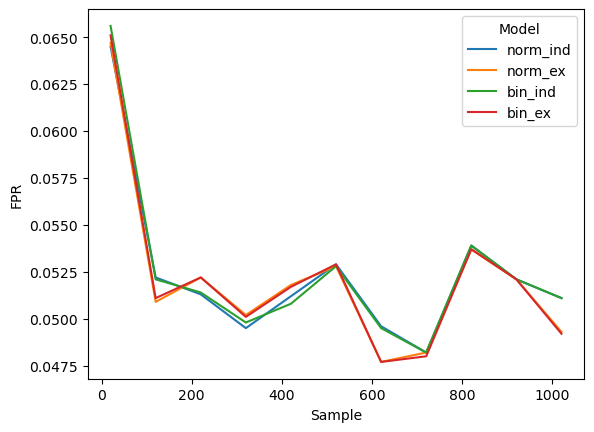

In [6]:
gee_fpr = pd.concat(gee_fpr)
sns.lineplot(data=gee_fpr, x="Sample", y="FPR", hue="Model")

У маленьких выборок контроль ошибки I рода плоховат, но не настолько плох, насколько мог бы быть. Дальше идёт неплохо. Интересно, что небольшие различия между моделями по FPR есть, и они не завязаны на тип распределения - они завязаны на ковариационную структуру. Причём это выглядит неконсистентно - где-то FPR больше для независимых, где-то для сменяемых. Откуда это берётся, я однозначно сказать не могу - но я бы грешил как раз на полупараметрический характер метода.

In [7]:
gee_fpr.to_csv("gee_fpr.csv", index=False)

#### FPR (неравные выборки)

In [8]:
with tqdm_joblib(desc="FPR GEE UNEQ", total=np.arange(0.05, 1.05, 0.1).size) as progress_bar:
    gee_fpr_uneq = Parallel(n_jobs=6)(delayed(lambda prop: regmodels_power_uneq(test_prop=prop))(sample_size) 
                                      for sample_size in np.arange(0.05, 1.05, 0.1))

FPR GEE UNEQ:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Prop', ylabel='FPR'>

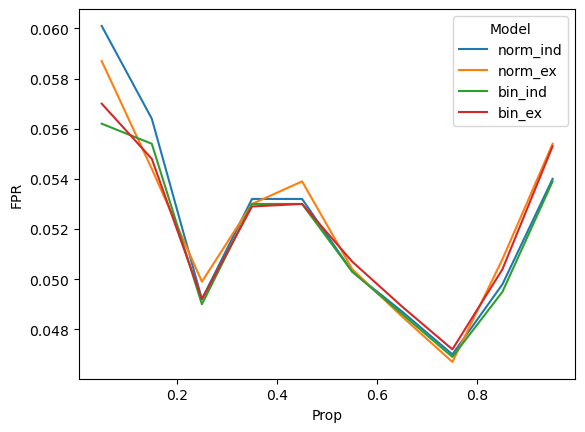

In [9]:
gee_fpr_uneq = pd.concat(gee_fpr_uneq)
sns.lineplot(data=gee_fpr_uneq, x="Prop", y="FPR", hue="Model")

Ситуация в целом выглядит крайне похожей на прошлую - снова высоковат FPR для маленьких выборок, дальше становится получше. И снова нет явного победителя между структурами.

In [10]:
gee_fpr_uneq.to_csv("gee_fpr_uneq.csv", index=False)

#### Мощность

In [11]:
with tqdm_joblib(desc="POWER GEE", total=11) as progress_bar:
    gee_power = Parallel(n_jobs=6)(delayed(lambda samp: regmodels_power_uneq(n=samp, test_multiplier=1.1))(sample_size) 
                                   for sample_size in range(20, 1100, 100))

POWER GEE:   0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

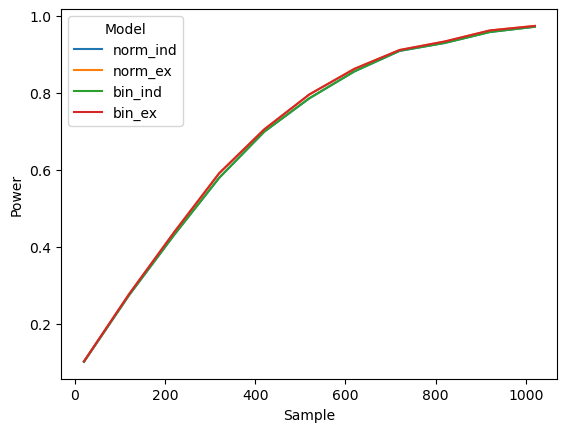

In [12]:
gee_power = pd.concat(gee_power)
sns.lineplot(data=gee_power, x="Sample", y="Power", hue="Model")

Показатели практически идентичны.

In [13]:
gee_power.to_csv("gee_power.csv", index=False)

#### Мощность (неравные выборки)

In [14]:
with tqdm_joblib(desc="POWER GEE UNEQ", total=np.arange(0.05, 1.05, 0.1).size) as progress_bar:
    gee_power_uneq = Parallel(n_jobs=6)(delayed(lambda prop: regmodels_power_uneq(test_prop=prop, test_multiplier=1.1))(sample_size) 
                                        for sample_size in np.arange(0.05, 1.05, 0.1))

POWER GEE UNEQ:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Prop', ylabel='Power'>

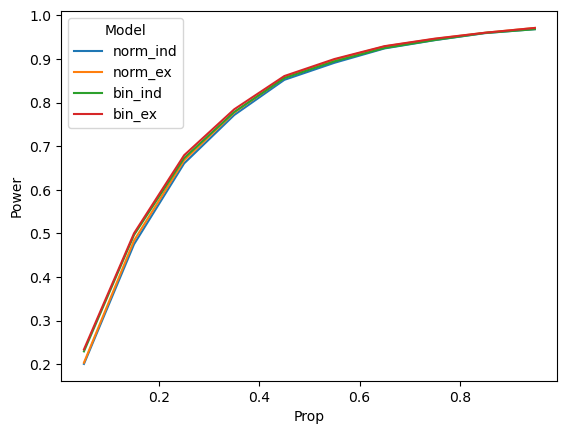

In [29]:
gee_power_uneq = pd.concat(gee_power_uneq)
sns.lineplot(data=gee_power_uneq, x="Prop", y="Power", hue="Model")

Ожидаемо видим небольшое преимущество логистической регрессии - прямо как тогда при анализе конверсии.

In [16]:
gee_power_uneq.to_csv("gee_power_uneq.csv", index=False)

## Сравниваем всё

А теперь поглядим, насколько хорошо модели справились по сравнению с тремя методами индустрии! Как оказалось, у меня было не совсем консистентное наименование и число колонок, поэтому мне пришлось кое-что переименовать и попереставлять. 

In [56]:
ind_fpr = pd.read_csv("industrial_fpr.csv").rename(columns={"Method":"Model"})
ind_fpr_uneq = pd.read_csv("industrial_fpr_uneq.csv").rename(columns={"Method":"Model", "Proportion":"Prop"})
ind_power = pd.read_csv("industrial_power.csv").rename(columns={"Method":"Model"})
ind_power_uneq = pd.read_csv("industrial_power_uneq.csv").rename(columns={"Method":"Model", "Proportion":"Prop"})

#### FPR

<Axes: xlabel='Sample', ylabel='FPR'>

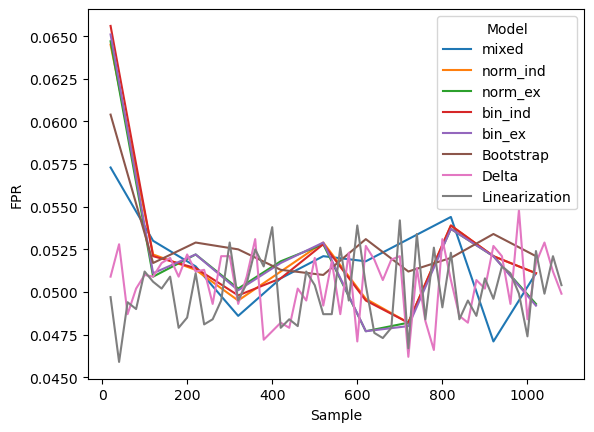

In [44]:
sns.lineplot(data=pd.concat([mixed_fpr[["Model", "Sample", "FPR"]], 
                             gee_fpr[["Model", "Sample", "FPR"]],
                             ind_fpr[["Model", "Sample", "FPR"]]]), 
                             x="Sample", y="FPR", hue="Model")

Для маленьких выборок дельта-метод и линеаризация явно в выигрыше. В остальном показатели сопоставимы.

#### FPR (неравные выборки)

<Axes: xlabel='Prop', ylabel='FPR'>

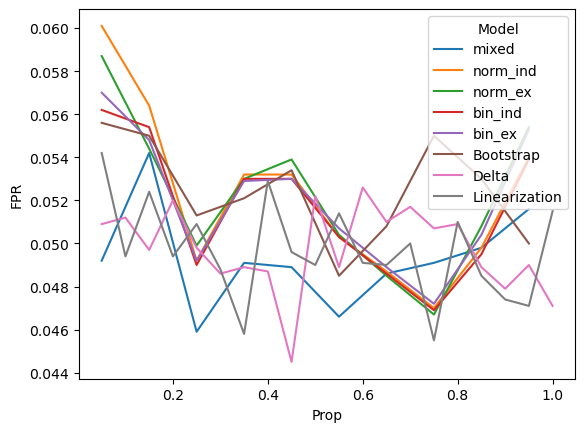

In [49]:
sns.lineplot(data=pd.concat([mixed_fpr_uneq[["Model", "Prop", "FPR"]], 
                             gee_fpr_uneq[["Model", "Prop", "FPR"]],
                             ind_fpr_uneq[["Model", "Prop", "FPR"]]]),
             x="Prop", y="FPR", hue="Model")

К дельта-методу и линеаризации присоединилась LME. 

#### Мощность

<Axes: xlabel='Sample', ylabel='Power'>

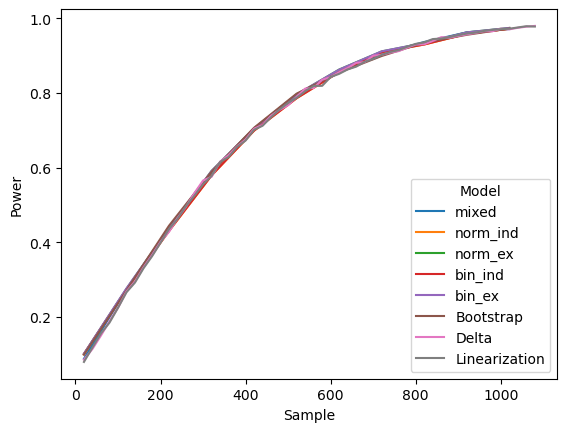

In [54]:
sns.lineplot(data=pd.concat([mixed_power[["Model", "Sample", "Power"]], 
                             gee_power[["Model", "Sample", "Power"]],
                             ind_power[["Model", "Sample", "Power"]]]), 
             x="Sample", y="Power", hue="Model")

Всё практически идентично.

#### Мощность (неравные выборки)

<Axes: xlabel='Prop', ylabel='Power'>

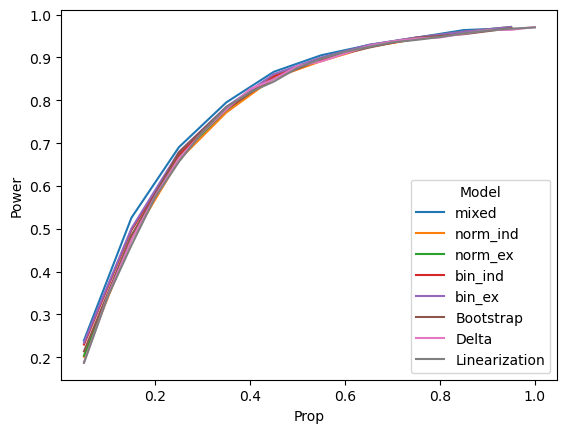

In [78]:
sns.lineplot(data=pd.concat([mixed_power_uneq[["Model", "Prop", "Power"]], 
                             gee_power_uneq[["Model", "Prop", "Power"]],
                             ind_power_uneq[["Model", "Prop", "Power"]]]), 
             x="Prop", y="Power", hue="Model")

Интересно, но похоже, что LME сохраняет мощность лучше всего, пусть и ненамного!

## Заключение

Какие выводы я в итоге делаю?

1. Если вам нужно просто сравнить две выборки - регрессионные модели вам не нужны. Выигрыша практически нет, а в скорости вы потеряете.
2. LME может быть полезна, когда вас интересует не только глобальный вывод "лучше-хуже", но и индивидуальные эффекты пользователей.
3. GEE могут быть полезны, когда индивидуальные эффекты вам не нужны, а именно регрессия нужна. При этом их имеет смысл использовать только тогда, когда между наблюдениями внутри пользователя реально есть какая-то дополнительная корреляция - в противном случае проще построить обычную регрессию с кластерными стандартными ошибками.